# Trabajo Práctico 1 
### Clasificación sobre datos simulados. 

## Introducción
Para este trabajo, hemos creado una función generadora de minions. Sobre cada minion, hemos medido 200 características que representan habilidades que poseen en distintas tareas (relacionadas al Mal).  

El doctor Nefario ha ideado una fórmula para determinar si un minion es o no apto para concretar su plan para conquistar el mundo. De esta manera ha etiquetado más de 500 minions. Lamentablemente, ha perdido dicha fórmula y necesita seguir decidiendo si nuevos minions son o no aptos para su macabro plan.

Es por esto que nuestro objetivo será construir clasificadores que estimen lo mejor posible la probabilidad de que nuevos minions sean o no aptos para concretar el plan de conquista y así facilitarle las cosas al doctor Nefario.

Por otra parte, ya que el doctor Nefario tuvo problemas con equipos que sobreestiman sus resultados, decidió guardarse varias etiquetas extra que no compartirá con nadie, y que luego utilizará para elegir al mejor equipo, al cual contratará para (de una vez por todas) conquistar el mundo. 


En concreto:

Tendrán disponible una matriz de datos $X$ de $500$ filas en donde cada fila $x^{(i)}$ representa un vector de $200$ características de cada instancia. Es decir, $\textbf{x}^{(i)} = x_1^{(i)}, \dots, x_{200}^{(i)}$ con $i$ entre $1$ y $500$. Además, tendrán y, un vector de $500$ posiciones con dos posibles valores: $True$ y $False$. 

Por otra parte, tendrán disponibles más instancias de evaluación $X_{competencia}$ sin las respectivas etiquetas que utilizaremos para evaluar sus resultados. 



In [1]:
# PREAMBULOS
%matplotlib inline

SEED = 1234

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, HTML
from time import time

import numpy as np
np.set_printoptions(precision=4)
np.random.seed(SEED)

import pandas as  pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)

pd.set_option('precision', 4)

import matplotlib.pyplot as plt

import seaborn as sns

import sklearn.ensemble
import sklearn.naive_bayes
import sklearn.svm
import sklearn.model_selection

from numpy.core.umath_tests import inner1d

from scipy.stats import uniform, expon


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score

from mi_clasificador_arbol_2 import MiClasificadorArbol
from learning_curve import plot_learning_curve


/Users/marialaraa/.virtualenvs/aa/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/marialaraa/.virtualenvs/aa/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Carga de datos
X = pd.read_csv("../TP1/X.csv", index_col="index")
y = pd.read_csv("../TP1/y.csv", index_col="index", dtype=int)  # Cargamos los valores booleanos (True y False)
                                                        # como números (1 y 0) para facilitar el manejo luego. 
    
X_competencia = pd.read_csv("../TP1/X_competencia1.csv", index_col="index")
y_competencia_ejemplo = pd.read_csv("../TP1/y_competencia_ejemplo.csv", index_col="index")
display(X)
display(y)
X.describe()

# Descomentar si quieren ver los datos para la competencia:
# display(X_competencia) 
# display(y_competencia_ejemplo)

,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,
0,1.4914,0.1644,1.2315,1.2429,1.5576,0.0455,0.1302,...,-1.1983,-0.0118,1.5375,-0.7727,-0.1401,2.0871,-0.8312
1,-0.2749,0.2780,-1.3108,0.6801,-0.5503,0.6359,-0.4478,...,1.2190,-0.3190,-0.6446,-0.0061,-1.2374,-1.3291,-1.3265
2,-0.2243,-0.5710,-0.2712,-0.1328,-1.0045,0.9315,-1.4507,...,0.9459,0.1430,-0.1989,-0.0393,-0.5866,2.2507,1.4925
3,0.5853,-0.8532,-0.2723,-0.5493,-2.9824,-0.1697,-0.0430,...,1.6488,-0.7363,-0.8866,-1.2717,-0.1493,0.2007,-1.4820
4,-1.4155,1.4187,0.6027,-0.7993,0.2939,-0.1796,-0.7140,...,1.1314,-0.4230,-0.2685,0.3045,-1.2245,-1.9421,1.5186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.2516,0.9375,-1.1980,0.4577,0.9287,0.5373,0.2476,...,0.5829,-0.5494,0.4607,1.2182,0.1025,3.0034,-0.0344
496,0.6246,-1.0590,0.9491,0.2687,0.6610,-1.6657,0.3982,...,-0.1075,0.8993,-0.4229,0.3977,-0.0808,-1.7054,-0.4786
497,0.2677,0.1802,0.7154,0.3542,-0.9023,-1.7792,-0.0121,...,0.8491,0.7469,0.2071,-1.0090,0.3317,-1.7513,-0.5397


,output
index,
0,0
1,0
2,0
3,0
4,1
...,...
495,1
496,0
497,1


,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
count,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,...,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000
mean,0.0384,0.0715,0.0056,-0.0103,-0.0436,-0.0208,-0.0571,...,-0.0187,0.0087,-0.0356,-0.1940,0.0250,0.0257,-0.0036
std,1.0153,0.9613,1.0360,1.0230,1.0647,0.9898,1.0000,...,0.9731,0.9716,1.0075,1.0246,0.9934,0.9940,0.9819
min,-3.1722,-2.4596,-2.8834,-3.7474,-2.9987,-3.2014,-3.6855,...,-2.9110,-2.9642,-2.5163,-3.9278,-2.4254,-2.6234,-2.8690
25%,-0.6090,-0.6207,-0.7180,-0.6594,-0.7177,-0.6510,-0.7073,...,-0.6441,-0.6509,-0.6613,-0.8689,-0.6466,-0.6354,-0.6855
50%,0.0602,0.0560,-0.0713,0.0612,-0.0097,-0.0407,-0.0771,...,-0.0473,0.0537,-0.0749,-0.1901,0.0185,-0.0332,-0.0797
75%,0.6334,0.7670,0.7066,0.6699,0.6616,0.6508,0.6029,...,0.6071,0.6860,0.5743,0.4636,0.7041,0.6575,0.6608
max,2.9702,2.7920,2.6905,2.8091,2.9823,2.9342,3.3240,...,3.0983,3.1469,2.9109,2.4942,3.1804,3.0034,2.5107


## Ejercicio 1

### Separación de datos

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos. En este punto pedimos que evalúen cómo separar sus datos para desarrollo y para evaluación tomando en cuenta la competencia. No consideramos necesario normalizar los datos. 

X_dev: (400, 200), y_dev: (400, 1) para desarrollo
X_eval: (100, 200), y_eval: (100, 1) para evaluación


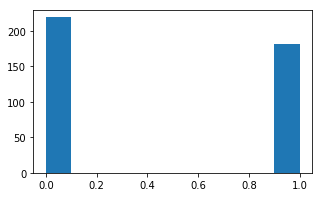

In [3]:
########################################################

X_dev, X_eval, y_dev, y_eval = sklearn.model_selection.train_test_split(X, y, random_state=SEED, test_size=0.2)

#########################################################

print("X_dev: {}, y_dev: {} para desarrollo".format(X_dev.shape, y_dev.shape))
print("X_eval: {}, y_eval: {} para evaluación".format(X_eval.shape, y_eval.shape))

plt.figure(figsize=(5, 3))
plt.hist(np.array(y_dev))  # muestra un histograma para la distribución de y.
plt.show()

Del total de los datos nos quedamos con un 0.2% como held out que no fue utilizado a lo largo del trabajo práctico. A la hora de la separación tuvimos en cuenta la distribución de los datos para que fuese equivalente en ambos grupos. 

## Ejercicio 2

### Construcción de modelos

Para este punto, la tarea consiste en construir y evaluar modelos de tipo árbol de decisión, de manera de obtener una estimación realista de la performance de los mismos. 

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default. 
2. Estimar la performance del modelo utilizando K-fold cross validation con K = 5, con las métricas “Accuracy” y “ROC AUC”. Para ello, se pide medir la performance en cada partición tanto sobre el fold de validación como sobre los folds de entrenamiento. Luego, completar la primera tabla.
3. Entrenar árboles de decisión para cada una de las siguientes combinaciones y completar la segunda tabla.

----

**EJERCICIO EXTRA**: Usar la implementación de árboles de decisión que realizaron para la guía de ejercicios de la materia. Adaptarla para que cumpla con la interfaz requerida por sklearn, asegurarse de que funcione con variables continuas y reproducir las tablas anteriores.   

----

In [4]:
X_dev_np = np.array(X_dev)
y_dev_np = np.array(y_dev).ravel()

kf = KFold(n_splits=5)

**Aclaración**: en este punto dividiremos el *X_dev*, definido inicialmente resultado de la separación del **held-out**, en dos sets: uno llamado *train*, con el que entrenaremos los modelos; y otro llamado *test*, con el que validaremos los modelos (*cross-validation*). Por otro lado, en los casos en los que usamos *k-fold cross-validation* seleccionaremos los *folds* sobre *X_dev*.

,Accuracy (train),Accuracy (val),AUC ROC (train),AUC ROC (val)
Perm,,,,
1,0.8031,0.5875,0.8845,0.5870
2,0.8500,0.6250,0.8813,0.6512
3,0.8187,0.6125,0.8810,0.5918
4,0.8281,0.7375,0.8618,0.7596
5,0.8094,0.5750,0.8656,0.5954


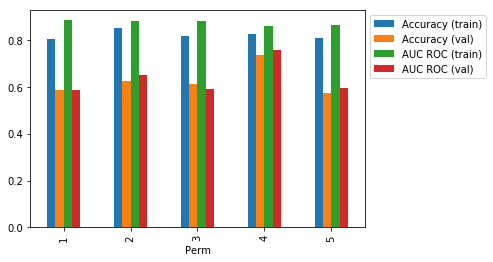

In [5]:
accuracies_training, accuracies_validation, aucs_training, aucs_validation = [], [], [], []

########################################################
# (1) y (2)
########################################################
for dev_index, eval_index in kf.split(X_dev_np):
    X_dev_folds, X_eval_folds = X_dev_np[dev_index], X_dev_np[eval_index]
    y_dev_folds, y_eval_folds = y_dev_np[dev_index], y_dev_np[eval_index]
    
    tree = DecisionTreeClassifier(max_depth=3)
    tree.fit(X_dev_folds, y_dev_folds)
    
    prediction_dev_c  = tree.predict(X_dev_folds) # _c es para cuando devuelve clase
    prediction_eval_c = tree.predict(X_eval_folds)
    
    accuracies_training.append(accuracy_score(y_dev_folds, prediction_dev_c))
    accuracies_validation.append(accuracy_score(y_eval_folds, prediction_eval_c))

    prediction_dev_p  = tree.predict_proba(X_dev_folds)[:,1] # _p es para cuando devuelve probabilidades
    prediction_eval_p = tree.predict_proba(X_eval_folds)[:,1]
    
    aucs_training.append(roc_auc_score(y_dev_folds, prediction_dev_p))
    aucs_validation.append(roc_auc_score(y_eval_folds, prediction_eval_p))
    
#########################################################

df = pd.DataFrame(index=range(1,6))
df.index.name = "Perm"
                  
df["Accuracy (train)"]   = accuracies_training   
df["Accuracy (val)"] = accuracies_validation  
df["AUC ROC (train)"]    = aucs_training      
df["AUC ROC (val)"]  = aucs_validation    


display(HTML("<h3> TABLA 1 </h3>"))
display(df)

df.plot(kind="bar")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

Como se puede observar, tanto los valores de Accuracy como los de AUC-ROC se mantienen estables entre los folds, tanto para el entrenamiento (train) como para la validación (val). Además, se observa una esperada baja en ambas métricas cuando pasamos de predecir los datos de entrenamiento a predecir los de validación. 

In [6]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_dev, y_dev, random_state=SEED, test_size=0.2)

X_train_np = np.array(X_train)
y_train_np = np.array(y_train).ravel()
X_test_np  = np.array(X_test)
y_test_np  = np.array(y_test).ravel()

In [7]:
########################################################
# (3)
########################################################

AUC_train, AUC_val = [], []

for criterio in ["gini", "entropy"]:
     for altura in [3, 5, None]:
        tree = DecisionTreeClassifier(max_depth=altura, criterion=criterio, random_state=SEED)
        tree.fit(X_train, y_train)
        
        pred_dev_p  = tree.predict_proba(X_train)[:,1]
        pred_eval_p = tree.predict_proba(X_test)[:,1]
        
        AUC_train.append(roc_auc_score(y_train, pred_dev_p))
        AUC_val.append(roc_auc_score(y_test, pred_eval_p))

df = pd.DataFrame(index=range(0,6))

df["Altura máxima"] = [3, 5, "Inifinito"] * 2
df["Criterio de evaluación de corte"] = ["Gini"] * 3 + ["Ganancia de Información"] * 3
df["AUC ROC promedio (training)"] = AUC_train # reemplazar por resultados_training
df["AUC ROC promedio (validación)"] = AUC_val # reemplazar por resultados_validation

   
display(HTML("<h3> TABLA 2 </h3>"))
display(df)

,Altura máxima,Criterio de evaluación de corte,AUC ROC promedio (training),AUC ROC promedio (validación)
0,3,Gini,0.8832,0.6934
1,5,Gini,0.9666,0.7201
2,Inifinito,Gini,1.0000,0.6562
3,3,Ganancia de Información,0.8869,0.6888
4,5,Ganancia de Información,0.9865,0.6729
5,Inifinito,Ganancia de Información,1.0000,0.6250


Nuevamente, al igual en en el punto anterior, se observa una mejor predicción sobre los datos vistos en el entrenamiento con respecto a los datos no vistos en el entrenamiento. Con respecto a los parámetros variados (altura máxima y criterio de evaluación de corte) podemos ver que: (1) la profundidad del árbol es determinante para el desempeño de nuestra clasificación, llegando incluso a modelos overfitteados cuando permitimos demasiada flexibilidad (mayor profundidad) a los mismos; y (2) no existe mucha diferencia entre utilizar Gini o Information Gain.

## [Extra] Mi Clasificador Árbol


In [8]:
# accuracies_training, accuracies_validation, aucs_training, aucs_validation = [], [], [], []

# for dev_index, eval_index in kf.split(X_dev_np):
#     X_dev_folds  = X_dev_np[dev_index]
#     X_eval_folds = X_dev_np[eval_index]
#     y_dev_folds, y_eval_folds = y_dev_np[dev_index], y_dev_np[eval_index]
#     tree = MiClasificadorArbol(list(X.columns), profundidad_max=3, criterion='gini')
#     tree.fit(X_dev_folds, y_dev_folds)

#     prediction_dev_c = tree.predict(X_dev_folds)
#     prediction_eval_c = tree.predict(X_eval_folds)

#     accuracies_training.append(accuracy_score(y_dev_folds, prediction_dev_c))
#     accuracies_validation.append(accuracy_score(y_eval_folds, prediction_eval_c))

#     prediction_dev_p = tree.predict_proba(X_dev_folds)
#     prediction_eval_p = tree.predict_proba(X_eval_folds)

#     aucs_training.append(roc_auc_score(y_dev_folds, prediction_dev_p))
#     aucs_validation.append(roc_auc_score(y_eval_folds, prediction_eval_p))

# ## Objetivo: accuracies_training, accuracies_validation, aucs_training y aucs_validation asignados
# #########################################################

# df = pd.DataFrame(index=range(1,6))
# df.index.name = "Permutación"
                  
# df["Accuracy (training)"] = accuracies_training   
# df["Accuracy (validación)"] = accuracies_validation  
# df["AUC ROC (training)"] = aucs_training      
# df["AUC ROC (validación)"] = aucs_validation    


# display(HTML("<h3> TABLA 1 </h3>"))
# display(df)

# # Descomentar las siguientes líneas para graficar el resultado
# df.plot(kind="bar")
# plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
# plt.show()

In [9]:
# ########################################################
# # (EE 3)
# ########################################################

# resultados_training = []
# resultados_validation = []

# for criterio in ["gini", "entropy"]:
#     for altura in [3, 5, None]:
#         tree = MiClasificadorArbol(list(X.columns), profundidad_max=altura, criterion=criterio)
#         tree.fit(X_train_np, y_train_np)
        
#         prediction_dev_p  = tree.predict_proba(X_train_np)
#         prediction_eval_p = tree.predict_proba(X_test_np)

#         resultados_training.append(roc_auc_score(y_train, prediction_dev_p))
#         resultados_validation.append(roc_auc_score(y_test, prediction_eval_p))

# df = pd.DataFrame(index=range(0,6))

# df["Altura máxima"] = [3, 5, "Inifinito"] * 2
# df["Criterio de evaluación de corte"] = ["Gini"] * 3 + ["Ganancia de Información"] * 3
# df["AUC ROC promedio (training)"] = resultados_training # reemplazar por resultados_training
# df["AUC ROC promedio (validación)"] = resultados_validation # reemplazar por resultados_validation

   
# display(HTML("<h3> TABLA 2 </h3>"))
# display(df)

## Ejercicio 3: Comparación de algoritmos


Se pide explorar distintas combinaciones de algoritmos de aprendizaje e hiperparámetros, de manera de buscar una performance óptima. Para este ejercicio es necesario que evalúen posibilidades utilizando la técnica de Grid Search. Como métrica de performance, usar siempre el área bajo la curva (AUC ROC) resultante de 5-fold cross-validation. 

Algoritmos a probar: KNN, árboles de decisión, LDA, Naive Bayes y SVM. Hiperparámetros: Revisar la documentación de cada uno para la búsqueda de combinaciones prometedoras.  

Se pide generar un reporte que contenga: 

1. Una descripción de las distintas combinaciones consideradas y su performance asociada (las que consideren relevantes, con al menos la mejor combinación para cada algoritmo). 

1. Una breve explicación de los factores que creen que produjeron dicho resultado. 

En este punto evaluaremos tanto los hiperparámetros elegidos como las conclusiones relacionadas a por qué piensan que ciertos algoritmos funcionan mejor que otros para estos datos. 



----

**EJERCICIO EXTRA**: Utilizar RandomizedSearchCV con rangos de parámetros que contengan a los utilizados en el GridSearch. Analizar si se encontraron mejores combinaciones de parámetros que no hayan sido tenidas en cuenta con el GridSearch y cuál fue la diferencia de tiempo de ejecución. 

----

In [10]:
def top_resultados(grid, top=5, algorithm_name=''):
    ## Si quieren, pueden utilizar esta función para imprimir las mejores combinaciones de su grid
    print(algorithm_name)
    print("Top {} combinaciones".format(top))
    df = pd.DataFrame(grid.cv_results_["params"])
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    display(df.sort_values(by="mean_score_validation", ascending=False).head(top))

In [11]:
X_np = np.array(X_dev)
y_np = np.array(y_dev).ravel()
n_iter = 100

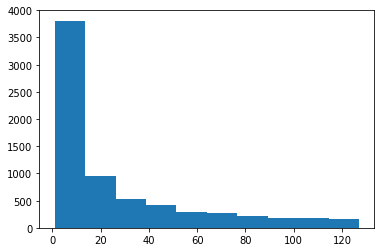

In [12]:
values_exponencial_distribution = np.int32(2 ** np.arange(0, 7, 0.001))
plt.hist(np.array(values_exponencial_distribution))
plt.show()

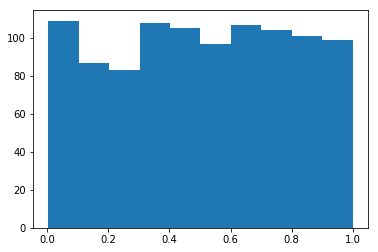

In [13]:
values_uniform_distribution = np.random.uniform(0, 1, 1000)
plt.hist(np.array(values_uniform_distribution))
plt.show()

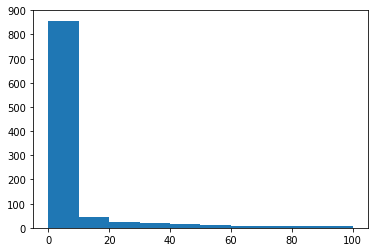

In [14]:
values_log_distribution = np.logspace(-5, 2, 1000)
plt.hist(np.array(values_log_distribution))
plt.show()

## KNeighbors Classifier 

In [15]:
parameters_knn = {
    'n_neighbors': np.unique(np.int32(2 ** np.arange(0, 7, 0.25))), 
    'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto']
}
clf = GridSearchCV(KNeighborsClassifier(weights='uniform'), parameters_knn, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, 88, 'KNeighbors Classifier - Grid Search')

parameters_knn = {
    'n_neighbors': np.int32(2 ** np.arange(0, 7, 0.001)), 
    'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto']
}

clf = RandomizedSearchCV(KNeighborsClassifier(weights='uniform'), parameters_knn, cv=5, n_iter=n_iter)
clf.fit(X_np, y_np)
top_resultados(clf, n_iter, 'KNeighbors Classifier - Randomized Search')

KNeighbors Classifier - Grid Search
Top 88 combinaciones


,algorithm,n_neighbors,mean_score_validation,mean_score_training
12,ball_tree,22,0.7750,0.7882
34,kd_tree,22,0.7750,0.7882
78,auto,22,0.7750,0.7882
40,kd_tree,64,0.7750,0.7769
18,ball_tree,64,0.7750,0.7769
...,...,...,...,...
45,brute,2,0.6750,0.8475
0,ball_tree,1,0.6675,1.0000
66,auto,1,0.6675,1.0000
22,kd_tree,1,0.6675,1.0000


KNeighbors Classifier - Randomized Search
Top 100 combinaciones


,algorithm,n_neighbors,mean_score_validation,mean_score_training
0,auto,40,0.7825,0.7788
99,ball_tree,40,0.7825,0.7788
33,kd_tree,69,0.7775,0.7825
31,ball_tree,22,0.7750,0.7882
72,auto,25,0.7750,0.7957
...,...,...,...,...
41,ball_tree,1,0.6675,1.0000
21,brute,1,0.6675,1.0000
69,auto,1,0.6675,1.0000
22,brute,1,0.6675,1.0000


Del total de 8 parametros probamos todas las permutaciones de los siguientes tres hiperparámetros para distintos valores:

- *n_neighbors*: número de vecinos utilizado por kneighbors query. Que por default es 5. 
- *weights*: es la función de peso que se utiliza en la predicción. Tiene como opciones: uniform (todos los puntos del vecindario pesan lo mismo), distance (los vecinos más cercanos tienen más peso) y callable (función definida por el usuario). 
- *algorithm*: es el algoritmo utilizado para computar los vecinos más cercanos. Puede ser: ball_tree, kd_tree, brute o auto. 

En una primera entrega del trabajo habíamos elegido hacer una búsqueda con Grid Search en un espacio lineal en un rango entre 1 y 107. En esta nueva entrega, la búsqueda consiste en un barrido de valores sobre una curva exponencial que a medida que crece va aumentando notablemente la cantidad de vecinos que prueba. El fundamento detrás de esto es que es conveniente probar valores distantes entre sí de vecinos para observar diferencias en los resultados del algoritmo. *n_neighbors* en la primera De las opciones de *weights* se dejó afuera *callable* por falta de experiencia. De *algorithm* se corrieron las opciones *ball_tree, kd_tree, brute y auto*.

Respecto de la performance. Los mejores rendimientos están dados por las combinaciones: auto/brute/kd_tree, 22, uniform. En todas ellas el accuracy promedio sobre los datos de validación es de alrededor de **0.77**, mientras que el accuracy promedio sobre los datos de entrenamiento es cercano a **0.79**. En las otras combinaciones el primer valor baja o se mantiene, mientras que el accuracy del training llega a 1, clara muestra de *overfitting*.

Pareciera que lo que marca la diferencia es el *weight*. Siempre mejora con uniform mientras que sobre ajusta con distance bajo las mismas combinaciones de los otros parámetros. 

Finalmente, se buscó optimizar la búsqueda de los hiperparámetros a través de Randomized Search. Ahora sí, sobre una distribución exponencial se tomó valores al azar. Lo esperable para estos casos es que la mayor cantidad de valores provengan de la primera parte de la exponencial que es la que crece más lento. Luego de 100 iteraciones se vió que la combinación de hiperparámetros para este modelo es con *algorithm* igual a *kd_tree*, la cantidad de vecinos 25 y *weigths* igual a *uniform*, con valores de *accuracy* similares a lo expresado previamente. 

## Linear Discriminant Analysis

In [16]:
parameters_LDA = {
    'shrinkage': [0, 1, 'auto'],
}

clf = GridSearchCV(LinearDiscriminantAnalysis(solver='lsqr'), parameters_LDA, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, 3, 'Linear Discriminant Analysis - Grid Search')

distributions_LDA = {
    'shrinkage': np.random.uniform(0, 1, 1000)
}

clf = RandomizedSearchCV(LinearDiscriminantAnalysis(solver='lsqr'), distributions_LDA, cv=5, n_iter=n_iter)
clf.fit(X_np, y_np)
top_resultados(clf, n_iter, 'Linear Discriminant Analysis - Randomized Search')

/Users/marialaraa/.virtualenvs/aa/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:294: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  self.coef_ = linalg.lstsq(self.covariance_, self.means_.T)[0].T


Linear Discriminant Analysis - Grid Search
Top 3 combinaciones


,shrinkage,mean_score_validation,mean_score_training
2,auto,0.7625,0.9331
1,1,0.7250,0.7563
0,0,0.6800,0.9794


Linear Discriminant Analysis - Randomized Search
Top 100 combinaciones


,shrinkage,mean_score_validation,mean_score_training
80,0.7597,0.7750,0.8763
24,0.7633,0.7750,0.8750
70,0.7793,0.7700,0.8694
57,0.8037,0.7700,0.8681
37,0.8046,0.7700,0.8669
...,...,...,...
15,0.0331,0.6825,0.9794
30,0.0041,0.6800,0.9800
34,0.0205,0.6750,0.9788
62,0.0076,0.6725,0.9813


El parámetro del modelo denominado 'shrinkage' se utiliza para mejorar la estimacion de las matrices de covarianza en casos en que el numero de ejemplos de entrenamiento es chico en relacion a la cantidad de features. Puede variar entre 0 y 1. Si es 0 se utiliza la matriz de covarianza obtenida a partir de los features. Si es 1, utiliza una matriz diagonal donde la diagonal son las varianzas de cada feature. Esto define la forma de la normal. Cuanto mas valores tengas por fuera de la diagonal mas rotada puede estar la distribucion. 
Lo que hicimos fue usar auto, y un barrido lineal entre 0 y 1 y para randomizedSearch un barrido uniforme.

Se observa que el modelo alcanza como máximo un accuracy promedio de **0.77** para los parámetros que se utilizan para su entrenamiento.

## Decision Tree Classifier

In [17]:
parameters_tree = {
    'criterion': ('gini', 'entropy'), 
    'splitter': ('random', 'best'), 
    'max_depth': np.unique(np.int32(2 ** np.arange(0, 7, 0.25)))
}
clf = GridSearchCV(DecisionTreeClassifier(), parameters_tree, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, 88, 'Decision Tree Classifier - Grid Search')

distributions_tree = {
    'criterion': ('gini', 'entropy'), 
    'splitter': ('random', 'best'), 
    'max_depth': np.int32(2 ** np.arange(0, 7, 0.001))
}

clf = RandomizedSearchCV(DecisionTreeClassifier(), distributions_tree, n_iter=n_iter, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, n_iter, 'Decision Tree Classifier - Randomized Search')

Decision Tree Classifier - Grid Search
Top 88 combinaciones


,criterion,max_depth,splitter,mean_score_validation,mean_score_training
50,entropy,4,random,0.7175,0.8088
82,entropy,76,random,0.6850,1.0000
70,entropy,26,random,0.6825,1.0000
6,gini,4,random,0.6825,0.8250
56,entropy,8,random,0.6825,0.9625
...,...,...,...,...,...
43,gini,107,best,0.6150,1.0000
25,gini,22,best,0.6125,1.0000
32,gini,45,random,0.6125,1.0000
33,gini,45,best,0.6000,1.0000


Decision Tree Classifier - Randomized Search
Top 100 combinaciones


,criterion,max_depth,splitter,mean_score_validation,mean_score_training
4,gini,4,random,0.7175,0.8225
48,entropy,3,random,0.7025,0.7669
46,entropy,1,random,0.7025,0.6787
9,entropy,2,random,0.6975,0.7225
91,gini,4,random,0.6975,0.8350
...,...,...,...,...,...
38,gini,5,best,0.6075,0.9381
3,gini,41,best,0.6075,1.0000
89,gini,35,random,0.6075,1.0000
47,entropy,80,random,0.5975,1.0000


Del total de 13 parámetros probamos todas las permutaciones de los siguientes tres hiperparámetros para distintos valores:
- *criterion*: es la función que mide la calidad del split. Las opciones son gini y entropy. 
- *splitter*: es la estrategia utilizada para elegir la partición en cada nodo. Puede ser best, para elegir el mejor corte o random que elige el mejor corte al azar. 
- *max_depth*: es la profundidad máxima del árbol. Puede ser seteada como int o como None. Si es None, los nodos se expanden hasta que todas las hojas son puras o hasta que contengan menos muestras que min_samples_split.

En una primera corrida los valores utilizados para *criterion* fueron *entropy* y *gini*, mientras que para *splitter* fueron *random* y *best*. Para el hiperparámetro *max_depth* buscamos con Grid Search entre los valores de una curva exponencial. A diferencia de la entrega anterior, lo que intentamos explorar en este caso fue la variación de los resultados con valores más diferenciados de profundidad bajo la hipótesis de que la diferencia entre un árbol de altura x y otro de altura x+1 es menor a la existente entre uno de altura x y otro de x**2.

Respecto de la performance, los mejores rendimientos estuvieron dados por las combinaciones gini/random/3 con un accuracy promedio para los datos de validación cercanos a **0.7** y con un accuracy promedio para los datos de entrenamiento cercanos a **0.77**. Para los valores muy altos de profundidad, se observan valores de *mean_score_training* de **1.00**. En estos casos, el modelo está sobreajustando sobre los datos de entrenamiento. 

Finalmente, en Randomized Search, se explora una variación de los valores de *max_depth* en una distribución exponencial. Nuevamente ocurre como en el caso anterior de Grid Search que los valores grandes tienden sobre ajustar y valores cercanos a 4, que varían levemente su performance dependiendo del *splitter* utilizado, dan buenos resultados. 

## Gaussian Naive Bayes

In [18]:
clf = GridSearchCV(GaussianNB(), {}, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, 1, 'Gaussian')

Gaussian
Top 1 combinaciones


,mean_score_validation,mean_score_training
0,0.73,0.7788


En este algoritmo no existen hiperparámetros que ajustar. Además, no se probará RandomizedSearch, ya que no hay parámetros con los cuales probar variantes. 

## Linear SVM

In [19]:
parameters_svm = {
    'C': [100, 10, 1, 0.1, 0.01, 0.0001, 0.00001]
}
clf = GridSearchCV(LinearSVC(), parameters_svm, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, 7, 'Linear SVM - Grid Search')

distributions_svm = {
    'C': np.logspace(-5, 2, 1000)
}

clf = RandomizedSearchCV(LinearSVC(), distributions_svm, n_iter=n_iter, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, n_iter, 'Linear SVM - Randomized Search')

Linear SVM - Grid Search
Top 7 combinaciones


,C,mean_score_validation,mean_score_training
4,1.0000e-02,0.7575,0.9813
3,1.0000e-01,0.7400,1.0000
5,1.0000e-04,0.7400,0.8000
0,1.0000e+02,0.7375,1.0000
1,1.0000e+01,0.7375,1.0000
2,1.0000e+00,0.7375,1.0000
6,1.0000e-05,0.7250,0.7631


Linear SVM - Randomized Search
Top 100 combinaciones


,C,mean_score_validation,mean_score_training
4,8.7285e-04,0.7800,0.9013
83,8.8705e-04,0.7800,0.9025
0,3.6104e-03,0.7775,0.9506
33,3.1732e-03,0.7775,0.9444
48,2.8804e-03,0.7775,0.9406
...,...,...,...
95,1.7308e-05,0.7275,0.7675
34,1.4968e-05,0.7275,0.7663
59,1.7031e-05,0.7275,0.7675
29,1.0496e-05,0.7250,0.7631


Variaremos el hiperparámetro *C* de modelo utilizando el *kernel* *lineal* por disposición de la consigna. 

El parametro *C* regula la proporción de clasificaciones incorrectas que se va a permitir a un determinado SVM. Valores de C más grandes resultarán en un hiperplano de margen más pequeño. 

Se varió C utilizando los valores [100, 10, 1, 0.1, 0.01, 0.0001, 0.00001] en Grid Search a lo largo de distintas iteraciones, observando que el *accuracy* sobre los datos de entrenamiento disminuyen al achicarse este valor. Esta mejora tiene su límite al llegar a valores de C muy bajos (alrededor de 1e-5), donde comienza a empeorar la clasificación. Esto se debe a que el entrenamiento permite encontrar hiperplanos muy permisivos con valores mal clasificados.

A continuación corrimos la búsqueda con Randomized Search para un rango de valores de C entre 0.00001 y 100 con distribución logarítmica, tomando 100 valores. Observamos nuevamente un comportamiento similar.

## Conclusiones Grid Search

Distintos sets de datos pueden ser mejor clasificados por unos u otros algoritmos. En este caso, las performances sobre los datos de validación siguen este orden decreciente: KNN, SVM, LDA, NB, DecisionTree.

Tanto Naive Bayes como LDA cuentan con la desventaja de hacer suposiciones sobre la distribución de los datos, por lo que es posible que estas suposiciones no se cumplan y que sea ésta la causa de que no se encuentren entre los mejores modelos.

Por otro lado, los otros tres son aquellos que no hacen suposiciones probabilísticas sobre los datos sino que se entrenan subdividiendo el espacio en el que se encuentran. Específicamente, aquellos que lo dividen de forma más compleja son los que generan mejor performance (SVM y KNN), mientras que los árboles de decisión, que dividen el espacio sólo con cortes rectos, fue el peor de los tres. 

In [20]:
df = pd.DataFrame()

df["Model"] = ['LDA', 'Decision Tree', 'Naive Bayes', 'SVM','KNN']
df["mean_score_validation"] = [0.7625, 0.6975, 0.73, 0.7700, 0.7750] # revisar! :)
df["mean_score_training"] = [0.9331, 0.8956, 0.7788, 0.9381, 0.7882]
display(df)

,Model,mean_score_validation,mean_score_training
0,LDA,0.7625,0.9331
1,Decision Tree,0.6975,0.8956
2,Naive Bayes,0.7300,0.7788
3,SVM,0.7700,0.9381
4,KNN,0.7750,0.7882


# Ejercicio 4: 
### Diagnóstico Sesgo-Varianza. 

En este punto, se pide inspeccionar dos de sus mejores modelos encontrados hasta ahora: el mejor modelo de tipo árbol de decisión y el mejor de tipo SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos (usar  grid search para encontrar una buena combinación de parámetros).  


**Atención**: Tener en cuenta que debemos seguir utilizando ROC AUC como métrica para estas curvas.

**ver**: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

----
**EJERCICIO EXTRA:** Utilizar RandomizedSearchCV para explorar la performance del algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).


----




Text(0,0.5,'ROC-AUC')

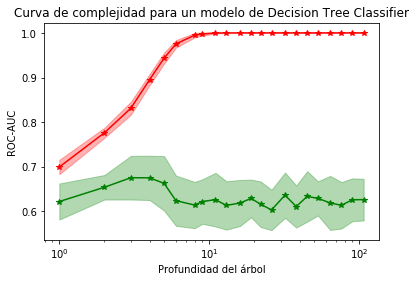

In [21]:
results = []
repetitions = 50
for i in range(repetitions):
    max_depths = np.unique(np.int32(2 ** np.arange(0, 7, 0.25)))
    auc_roc_train, auc_roc_test = [], []
    for max_depth in max_depths:
        tree = DecisionTreeClassifier(splitter='random', max_depth=max_depth)
        tree.fit(X_train_np, y_train_np)

        prediction_eval = tree.predict_proba(X_train_np)[:,1]
        auc_roc_train.append(roc_auc_score(y_train_np, prediction_eval))

        prediction_eval = tree.predict_proba(X_test_np)[:,1]
        auc_roc_test.append(roc_auc_score(y_test_np, prediction_eval))
    
    results.append((auc_roc_train, auc_roc_test))
    
u = np.array(results).mean(axis=0) # promedio
s = np.array(results).std(axis=0) # desviación

plt.fill_between(max_depths, u[0]-s[0], u[0]+s[0], color="red", alpha=0.3)
plt.fill_between(max_depths, u[1]-s[1], u[1]+s[1], color="green", alpha=0.3)

plt.plot(max_depths, u[0], marker="*", color="red")
plt.plot(max_depths, u[1], marker="*", color="green")

plt.xscale('log')
plt.title("Curva de complejidad para un modelo de Decision Tree Classifier")
plt.xlabel("Profundidad del árbol")
plt.ylabel("ROC-AUC")

Text(0,0.5,'ROC-AUC')

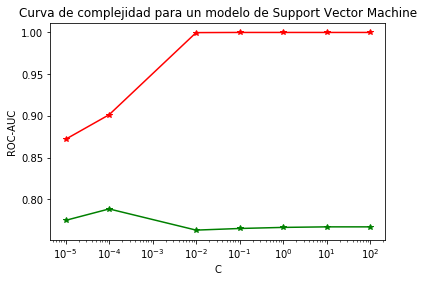

In [22]:
Cs = [100, 10, 1, 0.1, 0.01, 0.0001, 0.00001]
auc_roc_train, auc_roc_test = [], []

for C in Cs:
    svm = LinearSVC(C=C)
    svm.fit(X_train_np, y_train_np)

    decision = svm.decision_function(X_train_np)
    auc_roc_train.append(roc_auc_score(y_train_np, decision)) 
    
    decision = svm.decision_function(X_test_np)
    auc_roc_test.append(roc_auc_score(y_test_np, decision)) 

fig = plt.plot(Cs, auc_roc_train, marker="*", color="red")
fig = plt.plot(Cs, auc_roc_test, marker="*", color="green")
plt.xscale('log')
plt.title("Curva de complejidad para un modelo de Support Vector Machine")
plt.xlabel("C")
plt.ylabel("ROC-AUC")

Los errores de predicción pueden ser clasificados en errores de sesgo, errores de varianza y errores irreducibles. Los dos primeros pueden ser mejorados. Para hacerlo, el objetivo es que el método de aprendizaje logre disminuir al mismo tiempo sesgo y varianza. Se entiende por sesgo las suposiciones que los algoritmos hacen para poder estimar la función target que se desee aprender. Por varianza, la cantidad que varía la estimación al cambiar el set de datos de entrenamiento. Lo que suele ocurrir es que métodos más flexibles en cuanto a las suposiciones, es decir, con menor sesgo, resultan en una mayor varianza y, al revés. Se incurre, así, en un problema de trade-off entre sesgo y varianza. 

En el caso de los árboles de decisión, este trade-off depende de la profundidad del árbol, es decir, del parámetro max_depth. Un árbol de mayor profundidad hará muy pocas suposiciones sobre los datos y se adaptará muy bien a lo que le sea pasado como entrenamiento, aumentando así la varianza en gran medida al actuar sobre otro set de datos. 
En caso de los Support Vector Machines, el trade-off depende del parámetro C. Un aumento de este parámetro permite hacer más suposiciones sobre los datos achicando el margen de missclasification del hiperplano. Esto aumenta el sesgo y por consiguiente reduce la varianza.

Para observar esto en nuestros datos, se relizaron gráfico AUC-ROC vs profundidas del árbol para el caso de Decision Tree y AUC-ROC vs C para SVM. Graficando en cada caso los dos tipos de error, de manera tal de observar el rendimiento del modelo con la variación de los parámetros. 

En ambos casos el comportamiento observado es el esperable: 
Para los árboles, el sombreado se corresponde a las variaciones de las distintas corridas consecuencia del splitter seteado en random, se ve que partir de una profundidad 3 aproximadamente el rendimiento disminuye. 
Para SVM no se ven variaciones demasiado significativas. La conclusión que se puede obtener es que para evitar overfitting se decide tomar valores más pequeños de C. 

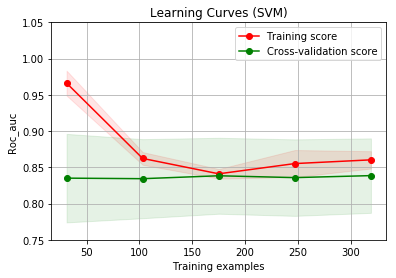

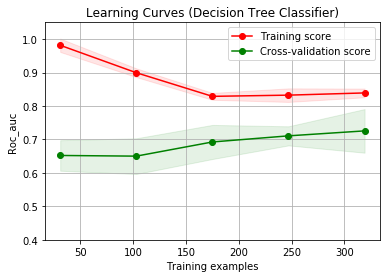

In [23]:
title = "Learning Curves (SVM)"
estimator = LinearSVC(C=0.00001)
plot_learning_curve(estimator, title, X_dev_np, y_dev_np, ylim=(0.75, 1.05), cv=5, n_jobs=4, scoring='roc_auc')

title = "Learning Curves (Decision Tree Classifier)"
estimator = DecisionTreeClassifier(max_depth=3, criterion='gini', splitter='random')
plot_learning_curve(estimator, title, X_dev_np, y_dev_np, (0.4, 1.05), cv=5, n_jobs=4, scoring='roc_auc')

plt.show()

La curva de aprendizaje muestra el score de validación y de entrenamiento de un estimador variando el número de las muestras de entrenamiento. Sirve para averiguar cuanto se beneficia el modelo de agregar nueva data de entrenamiento y si el estimador sufre más de error de sesgo o de varianza. Lo deseable sería que las dos líneas del gráfico converjan al mismo valor a medida que aumenta el tamaño del set de entrenamiento. En este caso, para el primer gráfico, a partir de 175 aproximadamente no sería necesario seguir aumentando los datos para obtener información relevante, mientras que en el segundo, agregar más datos podría llegar a disminuir la distancia entre las dos curvas. En particular podría aumentar la línea verde para así obtener un mejor modelo. 

In [24]:
parameters_rf = {
    'n_estimators': np.random.randint(10, 51, 1000), 
    'max_features':  np.random.randint(10, 150, 1000),
    'criterion': ('gini', 'entropy')
}
n_iter = 100
clf = RandomizedSearchCV(RandomForestClassifier(max_depth=3), parameters_rf, n_iter, cv=5) # se fija max_depth=3 por los resultados vistos previamente
clf.fit(X_np, y_np) 
top_resultados(clf, n_iter, 'RandomForestClassifier - Randomized Search')


RandomForestClassifier - Randomized Search
Top 100 combinaciones


,criterion,max_features,n_estimators,mean_score_validation,mean_score_training
87,entropy,14,24,0.7550,0.8606
52,entropy,69,39,0.7525,0.9012
68,entropy,129,48,0.7525,0.9238
20,gini,14,39,0.7500,0.8738
21,gini,142,10,0.7500,0.8813
...,...,...,...,...,...
48,gini,118,24,0.7175,0.8969
26,entropy,100,18,0.7175,0.8994
56,entropy,68,21,0.7175,0.8913
97,gini,61,37,0.7150,0.8981


Text(0,0.5,'ROC AUC')

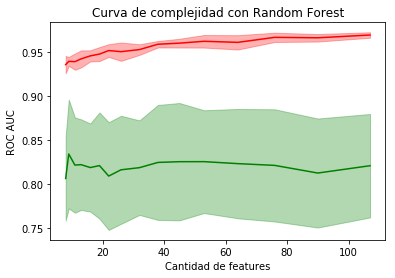

In [25]:
max_features = np.unique(np.int32(2 ** np.arange(3, 7, 0.25))) # va de 8 (un toque más que log2(200)) hasta 128 (un toque menos que la cant de features)
train_scores, dev_scores = validation_curve(RandomForestClassifier(n_estimators=21, criterion='entropy', max_depth=3), X_dev, np.ravel(y_dev), "max_features", max_features, cv=5, scoring='roc_auc')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

dev_mean = np.mean(dev_scores, axis=1)
dev_std = np.std(dev_scores, axis=1)

plt.plot(max_features, train_mean, label="Training score", color="red")
plt.plot(max_features, dev_mean, label="Cross-validation score", color="green")

plt.fill_between(max_features, train_mean - train_std, train_mean + train_std, color="red", alpha=0.3)
plt.fill_between(max_features, dev_mean - dev_std, dev_mean + dev_std, color="green", alpha=0.3)

plt.title("Curva de complejidad con Random Forest")
plt.xlabel("Cantidad de features")
plt.ylabel("ROC AUC")

El método Random Forest crea una serie de árboles de decisión. Su particularidad reside en que, al momento de hacerlo, cada vez que se considera un split, se elige como candidatos del split de manera random una muestra m de predictores de entre la totalidad del set p. Y de estos m elegidos al azar, el split solo puede elegir uno. Esto hace que una nueva muestra de predictores sea elegida cada vez. 

max_features determina el número de features considerado al momento de buscar el mejor split. Puede ocurrir: 

- Si es un int, entonces considera la cantidad max_features de features en cada split. 
- Si es float, entonces la cantidad max_features es una fracción fraction y se considera int(max_features * n_features) en cada split. 
- Si es sqrt, entonces max_features=sqrt(n_features)
- Si es log2, entonces max_features=log2(n_features)
- Si es None, entonces max_features=n_features




Se realizó una curva de complejidad para graficar ROC AUC vs cantidad de features. Esto permitió ver cómo afectan las variaciones de Max_Depth a la performance del modelo. De la curva verde, se observa como se mantiene estable la media de perfomance del modelo a medida que aumenta la cantidad de features. Esto es, que el modelo no mejora significativamente si estos crecen en número. De la curva roja, en cambio, se observa como a medida que aumenta max_features aparece una tendencia al sobre ajuste.

Por último, se grafica una curva de aprendizaje. Lo que se puede ver es que tanto el training como el cross validation score aumentan y se mantienen paralelos entre sí. Esto indica que el modelo puede beneficiarse de mayor cantidad de datos.

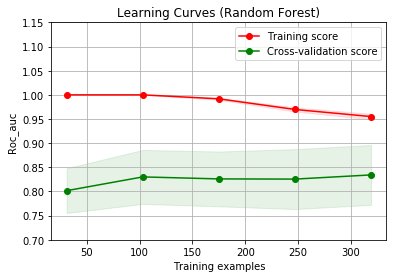

In [26]:
title = "Learning Curves (Random Forest)"
estimator = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=3)
plot_learning_curve(estimator, title, X_dev_np, y_dev_np, (0.7, 1.15), cv=5, n_jobs=4, scoring='roc_auc')

plt.show()

## Gradient Boosting Classifier

In [27]:
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

parameters_gb = {
    'min_samples_split': np.random.randint(20, 150, 50),
    'min_samples_leaf': np.random.randint(20, 150, 50),
    'max_depth': [3], # seteado a partir de los resultados vistos previamente
    'n_estimators': np.random.randint(10, 51, 1000), 
    'max_features':  np.random.randint(10, 150, 1000), 
    'loss' : ['deviance', 'exponential'],
    'subsample': [0.8],
}

n_iter = 100
clf = RandomizedSearchCV(GradientBoostingClassifier(), parameters_gb, n_iter, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, n_iter, 'Gradient Boosting Classifier - Randomized Search')

Gradient Boosting Classifier - Randomized Search
Top 100 combinaciones


,loss,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,subsample,mean_score_validation,mean_score_training
85,deviance,3,138,105,95,40,0.8,0.7675,0.8156
59,deviance,3,47,120,112,42,0.8,0.7675,0.8031
56,exponential,3,147,42,104,49,0.8,0.7675,0.9556
26,deviance,3,80,59,67,36,0.8,0.7650,0.8881
90,exponential,3,33,42,24,28,0.8,0.7650,0.8869
...,...,...,...,...,...,...,...,...,...
76,deviance,3,86,131,47,18,0.8,0.5475,0.5475
75,exponential,3,15,129,60,18,0.8,0.5475,0.5475
74,deviance,3,68,136,36,30,0.8,0.5475,0.5475
70,deviance,3,142,132,108,17,0.8,0.5475,0.5475


Notamos que para 200 arboles el modelo overfittea, por lo que en la segunda iteración decidimos agregar para que utilice menos cantidad de árboles.
Podemos observar, que no hay grandes mejoras entre utilizar Random Forest o Gradient Boosting como algoritmo de clasificación. 

## Competencias

La entrega del trabajo estará acompañada de una competencia en la cual deberán poner a prueba su mejor modelo y sobre todo, su capacidad para estimar sus resultados. 

Su tarea será estimar la performance (AUC ROC) que tendrá su mejor modelo en datos de evaluación (X_competencia). 

Para ello, deberán predecir las probabilidades de las distintas instancias con su modelo, enviarnos dichas probabilidades junto a una estimación con 4 decimales de cuál será el AUC ROC resultante y calcularemos el resultado real. El grupo que consiga acercarse más al valor real, será el grupo ganador.  

Recomendamos no perder de vista esta competencia en el momento de separar los datos en los primeros puntos. 

Para esto, junto con la entrega del informe, deberán enviar un archivo en formato csv con las columnas “index” y “output” (ver ejemplo de archivo en: [y_competencia_ejemplo.csv](https://github.com/pbrusco/aa-notebooks/blob/master/TP1/y_competencia_ejemplo.csv)) y un valor esperado de AUC ROC. 


## Entrega
- Contarán con un esqueleto en formato Jupyter Notebook en donde tendrán que completar las celdas faltantes (ya sea con explicaciones y gráficos o código). 
- El notebook final deberá ser entregado en formatos .html e .ipynb. Es necesario que los resultados puedan reproducirse al ejecutar todas las celdas en orden (Kernel - Restart and Run All) utilizando las bibliotecas requeridas en el archivo: requirements.txt del repositorio. 
- Tienen tiempo hasta las 23:59hs del día miércoles 17/10/2018. La entrega se debe realizar a través del campus virtual y debe contener el informe.
- El trabajo deberá elaborarse en grupos de 3 personas.
- Se podrán pedir pruebas de integridad y autoría; es decir, verificar que la salida solicitada es fruto del modelo presentado y que el modelo fue construido según lo requerido en este enunciado.
- La evaluación será grupal y se basará en la calidad del informe (presentación, claridad, prolijidad); la originalidad, practicidad y coherencia técnica de la solución; la corrección y solidez de las pruebas realizadas.
- En el primer parcial se incluirá una pregunta sobre la solución entregada. Esa pregunta no influirá en la nota del parcial, pero sí en la nota individual del TP1.
- La participación en la competencia es obligatoria. De todas maneras, el resultado no incidirán en la nota de la materia.
- Los ejercicios extra son opcionales para aprobar el TP, pero son obligatorios para promocionar la materia.


In [28]:
clf = KNeighborsClassifier(n_neighbors = 40, algorithm='kd_tree', weights= 'uniform')
clf.fit(X_np, y_np)

prediction_eval_c = clf.predict(X_eval)
accuracy = accuracy_score(y_eval, prediction_eval_c)
prediction_eval_p = clf.predict_proba(X_eval)[:,1]
roc = roc_auc_score(y_eval, prediction_eval_p)

print('accuracy', accuracy)
print('AUC - ROC', roc)

accuracy 0.68
AUC - ROC 0.7996794871794871


Finalmente, luego de haber entrenado y testeado varios modelos, con varias combinaciones de hiperparámetros decidimos seleccionar KNN con los siguientes valores:

- *n_neighbors = 40*
- *algorithm   = kd_tree*
- *weights     = uniform*

El accuracy de este modelo se encontraba alrededor de **0.78**, tanto para los datos de entrenamiento como para los datos de testeo utilizados durante el desarrollo. Sin embargo, para estimar el valor que se obtendrá al clasificar los datos de la competencia utilizados datos que no fueron utilizados en ninguna otra etapa: los datos held-out.

Al entrenar el modelo con todos los datos de desarollo y testearlo con los datos held-out observamos un esperado descenso en el *accuracy*, obteniendo un valor de **0.69**. Por otro lado, el valor de AUC-ROC es de **0.8**, valores que esperamos repetir con los datos predichos para la competencia.


In [29]:
prediction_competencia = clf.predict(X_competencia)
y_competencia = pd.DataFrame(data=prediction_competencia, index=X_competencia.index)
y_competencia.to_csv('y_competencia.csv')